In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For use on local machine
%cd ..

C:\Users\tzeng1\repos\ERM_GDRO


In [11]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is 3EC7-ED00

 Directory of C:\Users\tzeng1\repos\ERM_GDRO

08/18/2022  09:48 PM    <DIR>          .
08/18/2022  09:48 PM    <DIR>          ..
08/16/2022  11:43 AM             2,050 .gitignore
08/16/2022  10:45 AM    <DIR>          .ipynb_checkpoints
08/17/2022  02:23 PM            16,384 .run.py.swp
08/17/2022  12:25 PM    <DIR>          __pycache__
08/02/2022  12:36 AM       265,496,373 CC_ERM.wt
08/18/2022  09:26 AM           406,464 cc_sup_erm.csv
08/17/2022  02:23 PM            32,629 civil_comments_script.ipynb
08/09/2022  09:49 AM    <DIR>          data
08/11/2022  07:56 PM             2,943 dataloaders.py
08/16/2022  10:28 AM             1,574 datasets.py
08/18/2022  09:29 AM             5,817 extract_features.py
08/17/2022  02:23 PM             1,084 feature_sc.txt
08/18/2022  03:30 PM         1,890,848 feature_vis.ipynb
08/17/2022  10:21 AM       277,282,918 features_base.csv
08/16/2022  11:13 AM       277,111,864 feature

# Results Visualization

Data loading and plotting functions to visualize the results given by run.py  
Put the path of the folder containing the results in load_dir and run the cells to see results

## Defining functions & parameters

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# .csv to load results from
load_path = './WB_cris_berm_berm.csv' #'test_results/mnist_independent/accuracies.csv'

In [13]:
# Get train set subclass sizes for waterbirds and find correction factors for the overall accuracy
metadata = pd.read_csv('data/waterbirds_v1.0/metadata.csv')
correction = np.array(metadata[metadata['split'] == 0].groupby(['y', 'place']).size(), dtype=np.float64)
correction /= sum(correction)
correction

array([0.72950991, 0.03837331, 0.01167883, 0.22043796])

In [14]:
def plot_acc(drop_epochs=[], err_margin=0, accuracy_correction=None):
    results_df = pd.read_csv(load_path, index_col=["trial", "epoch", "subtype"])
    if accuracy_correction is not None:
        all_but_overall = results_df.stack().unstack(level=2).drop(columns="Overall")
        corrected_overall = (all_but_overall * accuracy_correction).sum(axis=1)
        all_but_overall['Overall'] = corrected_overall.values
        results_df = all_but_overall.stack().unstack(level=2)
    
    N = max(results_df.index.get_level_values(0)) + 1
    algorithms = results_df.columns
    
    trial_means = results_df.stack().unstack(level=0).mean(axis=1).unstack(level=2)
    trial_errs = results_df.stack().unstack(level=0).std(axis=1).unstack(level=2) / (N ** 0.5)

    trial_means.drop(drop_epochs, level=0, axis=0, inplace=True)
    hide = []
    
    subtypes = ["Overall", "0", "1", "2", "3"]

    f, a = plt.subplots(1, 5)

    # plot subtypes sensitivity

    for i in range(len(subtypes)):
        plot_data = trial_means.drop(columns=hide).xs(subtypes[i], level=1)
        plot_data.plot(ylim=[0.5,1],xlabel="Epoch",ylabel="Accuracy" if subtypes[i] == 'Overall' else 'Sensitivity',kind='line',title=subtypes[i],ax=a[i],figsize=(30, 6),grid=True,linewidth=1)
        plot_errs = trial_errs.drop(columns=hide).xs(key=subtypes[i], level=1)
        for col in plot_data.columns:
            a[i].fill_between(list(plot_data.index), plot_data[col] + err_margin * plot_errs[col], plot_data[col] - err_margin * plot_errs[col], alpha=0.25)
        

In [15]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind

def ttest(p_threshold=0.05):
    print(f't-tests with significance threshold p<{p_threshold}\n')
    ttest_dataframes = {}

    loaded_accuracies = pd.read_csv(load_path)
    N = max(loaded_accuracies["trial"]) + 1
    epochs = max(loaded_accuracies["epoch"]) + 1
    subtypes = list(loaded_accuracies["subtype"].unique())
    algorithms = loaded_accuracies.columns

    results = loaded_accuracies.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')
    results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

    for s in range(len(subtypes)):
        epoch = epochs - 1

        subtype_data = results_df.xs(subtypes[s], level=2).xs(epoch, level=1)
        erm_data = subtype_data["ERMLoss"].values

        print(subtypes[s])
        for algorithm in results_df.columns:
            if algorithm != "ERMLoss":
                algorithm_data = subtype_data[algorithm].values
                stat, p = ttest_ind(algorithm_data, erm_data)

                print(f'ERMLoss: {erm_data.mean():.3f}, 1.96*stdErr: {(1.96 * erm_data.std(ddof=1) / (len(erm_data) ** 0.5)):.2e}')
                print(f'{algorithm}: {algorithm_data.mean():.3f}, 1.96*stdErr: {(1.96 * algorithm_data.std(ddof=1) / (len(algorithm_data) ** 0.5)):.2e}')
                if p < p_threshold:
                    print(f'{algorithm if stat > 0 else "ERMLoss"} greater with p = {p:.2e}')
                else:
                    print(f'No significant difference with p = {p:.2e}')
                print()

## Show results

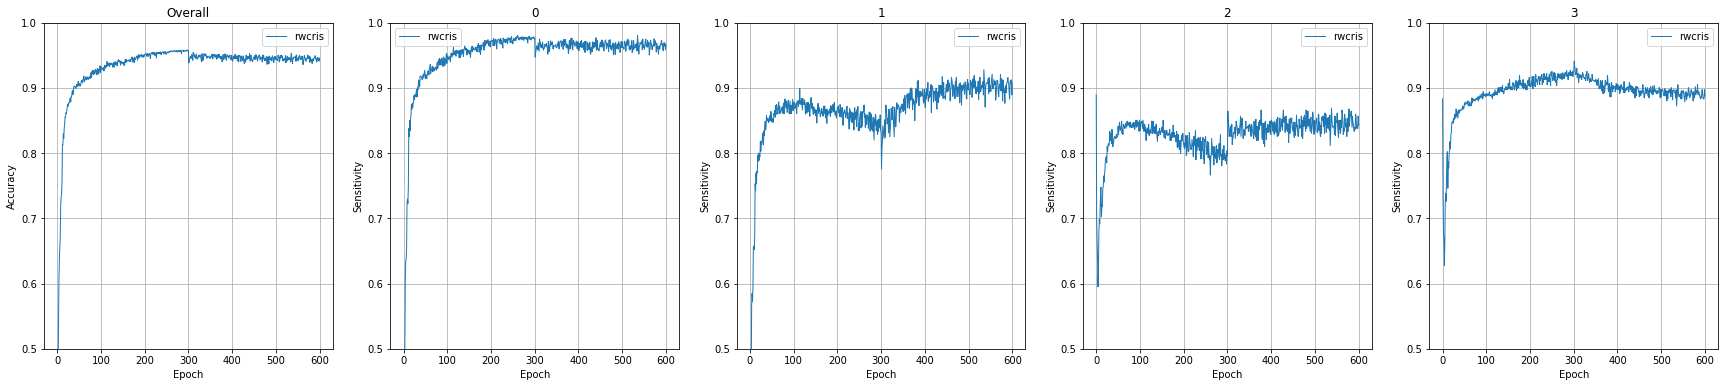

In [16]:
plot_acc(err_margin=1.96, accuracy_correction=correction)

In [17]:
results_df = pd.read_csv(load_path, index_col=["trial", "epoch", "subtype"])
all_but_overall = results_df.stack().unstack(level=2).drop(columns="Overall")
corrected_overall = (all_but_overall * correction).sum(axis=1)
all_but_overall['Overall'] = corrected_overall.values
results_df = all_but_overall.stack().unstack(level=2)

In [18]:
results_df.stack().unstack(level=0).mean(axis=1).unstack(level=0).min(axis=0).max()

0.8691588785046729

In [20]:
results_df.stack().unstack(level=0).mean(axis=1).xs(level='epoch', key=538)

subtype        
0        rwcris    0.951663
1        rwcris    0.870510
2        rwcris    0.869159
3        rwcris    0.904984
Overall  rwcris    0.937296
dtype: float64

In [51]:
ttest(p_threshold=0.05)

t-tests with significance threshold p<0.05



KeyError: 'ERMLoss'